# 逻辑回归

### 回归问题与分类问题

| 问题类型 | 回归 | 分类 |
| ------ | ------ | ------ |
|  因变量 | 连续的 | 离散的 |
| 模型 | 线性回归，支持向量回归，朴素贝叶斯，神经网络 | 逻辑回归，支持向量机，朴素贝叶斯，神经网络 |
| 应用场景 | 预测价格、销量、利率、天气（温度、湿度） | 检测垃圾邮件、诈骗、疾病，文章分类 |


In [293]:
import threading, math
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

#### Sigmoid函数

$ h_\theta (x) = \frac{1}{1+e^{-x}} $

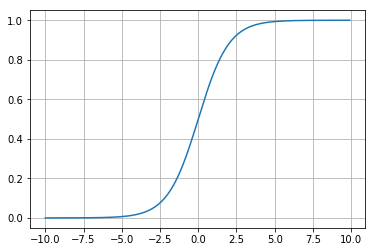

In [294]:
def sigmoid(x):
    return (1 / ( 1 + np.exp(-x)))

x_sig = np.arange(-10, 10, 0.1)
plt.plot(x_sig, sigmoid(x_sig))
plt.grid()

### 实例演示1

### 生成随机数据

In [295]:
def generateRandomData(m, x_scale=(0, 1), noise_factor=0.4):
    (x_min, x_max) = x_scale
    x_range = x_max - x_min # max value of x
    x = np.random.random(size=(m, 2))
    noise = (np.random.random(size=(m, 1)) - 0.5 ) * x_range * noise_factor
    y = (sigmoid(x[:,0].reshape(m ,1) + x[:,1].reshape(m ,1) + noise - x_range) > 0.5).astype('int')
    X = np.c_[np.ones(m), x]
    return (X, y)

In [296]:
m = 100 # number of sample data
X, y = generateRandomData(m)
print(sum(y.flatten()))

52


#### 对数据进行可视化

In [297]:
def plotData(X, y, xlabel='x_1', ylabel='x_2', axes=None, label_pos='positive', label_neg='negative'):
    pos_index = y[:, 0] == 1
    neg_index = y[:, 0] == 0
    if axes == None:
        axes = plt.gca()
    axes.scatter(X[pos_index][:,1], X[pos_index][:,2], marker='+', c='r', label=label_pos)
    axes.scatter(X[neg_index][:,1], X[neg_index][:,2], marker='*', c='b', label=label_neg)
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.legend();

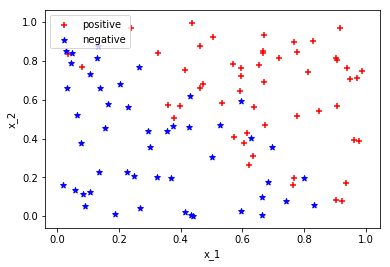

In [298]:
plotData(X, y)

### 逻辑回归

#### 假设函数

$ \hat{y} = h_\theta (x) = g(\theta^T x)  $   
$ g(z)= \frac{1}{1+e^{-z}} $

其中，g表示sigmoid函数

#### 代价函数

$  J(\theta)=\frac{1}{2m} \sum_{i=1}^m{ -y^{(i)}log(h_\theta(x)) - (1-y^{(i)})log(1 - h_\theta(x)) }  $

In [299]:
def computeCost(theta, X, y):
    h = sigmoid(X.dot(theta))
    J = -1/m * (np.log(h).T.dot(y) + np.log(1-h).T.dot(1-y))
    if np.isnan(J[0]):
        return np.inf
    return (J[0])

#### 代价函数的梯度

$  \frac{\partial{J}}{\partial{\theta}} = \frac{1}{m}\sum_{i=1}^m{(h_\theta (x^{(i)}) - y^{(i)} )}) \cdot x_j^{(i)} $ 

推导过程：   
<img src="./images/LR-gradient-calc.png" align="left" style="width:50%" />    

In [300]:
def costGradient(theta, X, y):
    h = sigmoid(X.dot(theta.reshape(-1,1)))
    grad = 1/m * X.T.dot(h-y)
    return (grad.flatten())

### 训练逻辑回归模型

In [301]:
# theta_init = np.random.random(X.shape[1])
theta_init = np.zeros(X.shape[1])
cost = computeCost(theta_init, X, y)
grad = costGradient(theta_init, X, y)
print('cost: %s, Gradient: %s, theta: %s' %(cost, grad, theta_init))

cost: 0.6931471805599452, Gradient: [-0.02       -0.09523117 -0.07875562], theta: [0. 0. 0.]


#### 梯度下降法迭代

In [302]:
def gradientDescent(X, y, theta, alpha, num_iters):
    # save all cost values over iterations
    J_history = np.zeros(num_iters)
    theta_history = np.zeros((num_iters, 3))
    for iter in range(num_iters):
        hypothesis = sigmoid(X.dot(theta))
        theta -= alpha / m * costGradient(theta, X, y) # core step of gradient descent
        J_history[iter] = computeCost(theta, X, y)
        theta_history[iter,:] = theta.reshape(1,3)
    return (theta, J_history, theta_history)

[-10.47650583  11.52625195  10.07755298]


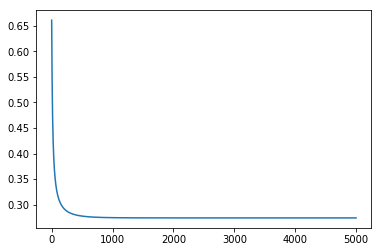

In [303]:
alpha = 300
num_iters = 5000
theta_gd, J_history, theta_history = gradientDescent(X, y, theta_init, alpha, num_iters)
print(theta_gd)
plt.plot(J_history)

#### scipy 中的 [minimize](https://docs.scipy.org/doc/scipy-0.19.0/reference/generated/scipy.optimize.minimize.html) 方法  
- [雅可比矩阵](https://zh.wikipedia.org/wiki/%E9%9B%85%E5%8F%AF%E6%AF%94%E7%9F%A9%E9%98%B5)

In [304]:
res = minimize(computeCost, theta_init, args=(X,y), method=None, jac=costGradient, options={'maxiter': 10000})
theta_scipy = res.x
print(theta_scipy)

[-10.47650583  11.52625195  10.07755298]


#### 验证测试集的准确率

生成测试数据

In [305]:
x_test, y_test = generateRandomData(1000)

In [306]:
def predict(theta, x, threshold=0.5):
    return (sigmoid(x.dot(theta.T)) >= threshold).astype('int')

In [307]:
accuracy_scipy = sum(predict(theta_scipy, x_test) == y_test.flatten()) / y_test.size
accuracy_gd = sum(predict(theta_gd, x_test) == y_test.flatten()) / y_test.size
print(accuracy_scipy, accuracy_gd)

0.903 0.903


#### 决策边界

In [308]:
print(theta_scipy, theta_gd)

[-10.47650583  11.52625195  10.07755298] [-10.47650583  11.52625195  10.07755298]


In [309]:
def plotIteration(num_iters,x_plot_1, x_plot_2):
    alpha = 100
    theta_init = np.zeros(X.shape[1])
    theta_gd_plt, _, _ = gradientDescent(X, y, theta_init, alpha, num_iters)
    
    def getHypothesis(theta):
        return sigmoid(np.c_[np.ones((x_plot_1.ravel().shape[0],1)), x_plot_1.ravel(), x_plot_2.ravel()].dot(theta)).reshape(x_plot_1.shape)

    # calculate hypothesis line based on theta value
    h_scipy = getHypothesis(theta_scipy)
    h_gd = getHypothesis(theta_gd_plt)
    
    plt.contour(x_plot_1, x_plot_2, h_gd, [0.5], colors='g')   # gradient descent
    plt.contour(x_plot_1, x_plot_2, h_scipy, [0.5], colors='k')  # scipy     

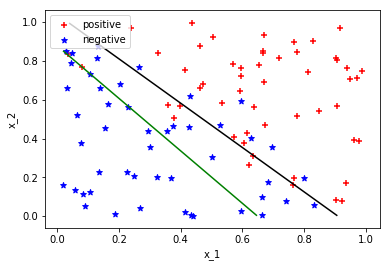

In [313]:

plotData(X, y)
x_plot_1, x_plot_2 = np.meshgrid(np.linspace(X[:,1].min(), X[:,1].max()), np.linspace(X[:,2].min(), X[:,2].max()))
    
plotIteration(20, x_plot_1, x_plot_2)

### 多项式逻辑回归与正则化

In [193]:
def calcDist(c1, c2):
    return math.sqrt(math.pow(c1[0] - c2[0], 2) + math.pow(c1[1] - c2[1], 2))
def generateRadialData(m, radius, noise_factor=0.2):
#     center_x = [-0.5, 0.5][np.random.randint(0,2)]
    angle = np.random.random((m,1)) * 2 * np.pi
    r_min = radius * 0.3
    r = r_min + np.random.random((m,1)) * radius
    x = np.c_[np.cos(angle) * r, np.sin(angle) * r]  # coordinates of data
    noise_x = (np.random.random((m,1)) - 0.5) * radius * noise_factor
    y = (sigmoid(r + noise_x - 0.5*radius - r_min) > 0.5).astype('int')
    return (x, y)

In [131]:
def costFunctionReg(theta, reg, *args):
    m = y.size
    h = sigmoid(XX.dot(theta))
    
    J = -1*(1/m)*(np.log(h).T.dot(y)+np.log(1-h).T.dot(1-y)) + (reg/(2*m))*np.sum(np.square(theta[1:]))
    
    if np.isnan(J[0]):
        return(np.inf)
    return(J[0])

In [132]:
def gradientReg(theta, reg, *args):
    m = y.size
    h = sigmoid(XX.dot(theta.reshape(-1,1)))
    grad = (1/m)*XX.T.dot(h-y) + (reg/m)*np.r_[[[0]],theta[1:].reshape(-1,1)]
    return(grad.flatten())

In [180]:
dx= 10
print(calcDist([2,2],[0,0]))

2.8284271247461903


(200, 21) (200, 1)
93


0.6931471805599452

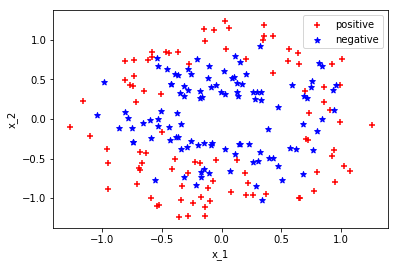

In [227]:
m = 200
degree = 5
X, y = generateRadialData(m, 1, 0.7)
poly = PolynomialFeatures(degree)
XX = poly.fit_transform(X)
print(XX.shape, y.shape)
plotData(XX, y)
print(np.sum(y))

initial_theta = np.zeros(XX.shape[1])
costFunctionReg(initial_theta, 1, XX, y)

80.0
81.0
79.0
77.5


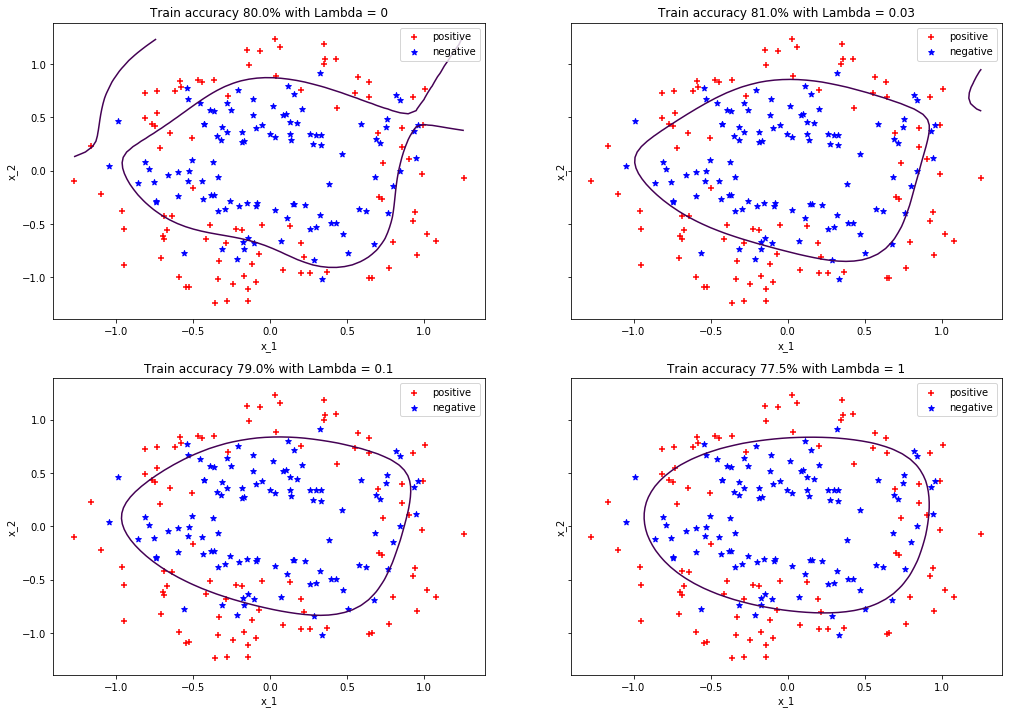

In [234]:
fig, axes = plt.subplots(2,2, sharey = True, figsize=(17,12))

for i, C in enumerate([0, 0.03, 0.1, 1]):
    
    # Optimize costFunctionReg
    res2 = minimize(costFunctionReg, initial_theta, args=(C, XX, y), method=None, jac=gradientReg, options={'maxiter':3000})
    # Accuracy
    accuracy = 100*sum(predict(res2.x, XX) == y.ravel())/y.size    
    print(accuracy)

    x1_min, x1_max = X[:,0].min(), X[:,0].max(),
    x2_min, x2_max = X[:,1].min(), X[:,1].max(),
    xx1, xx2 = np.meshgrid(np.linspace(x1_min, x1_max), np.linspace(x2_min, x2_max))
    h = sigmoid(poly.fit_transform(np.c_[xx1.ravel(), xx2.ravel()]).dot(res2.x))
    h = h.reshape(xx1.shape)
    
    plotData(XX, y, axes=axes.flatten()[i])
    
    axes.flatten()[i].contour(xx1, xx2, h, [0.5])
    axes.flatten()[i].set_title('Train accuracy {}% with Lambda = {}'.format(np.round(accuracy, decimals=2), C))